Import Statements

In [ ]:
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.initializers import Constant
from keras.models import Sequential
from keras.utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Embedding, Dropout, Flatten, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Embedding
from sklearn.metrics import confusion_matrix
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sn
import pandas as pd
import numpy as np
import string
import gensim

Loading Data

In [ ]:
samples = open("sentiment.txt","r", encoding="utf8")
lyrics = []
Y = []

# I have pre-process the data will web scraping in order to avoid overflowing url request
for a_sample in samples:
  if a_sample[0] == " ":
    continue
  lyrics.append(a_sample[2:-2])
  Y.append(int(a_sample[0]))

*Pie* Chart Dataset

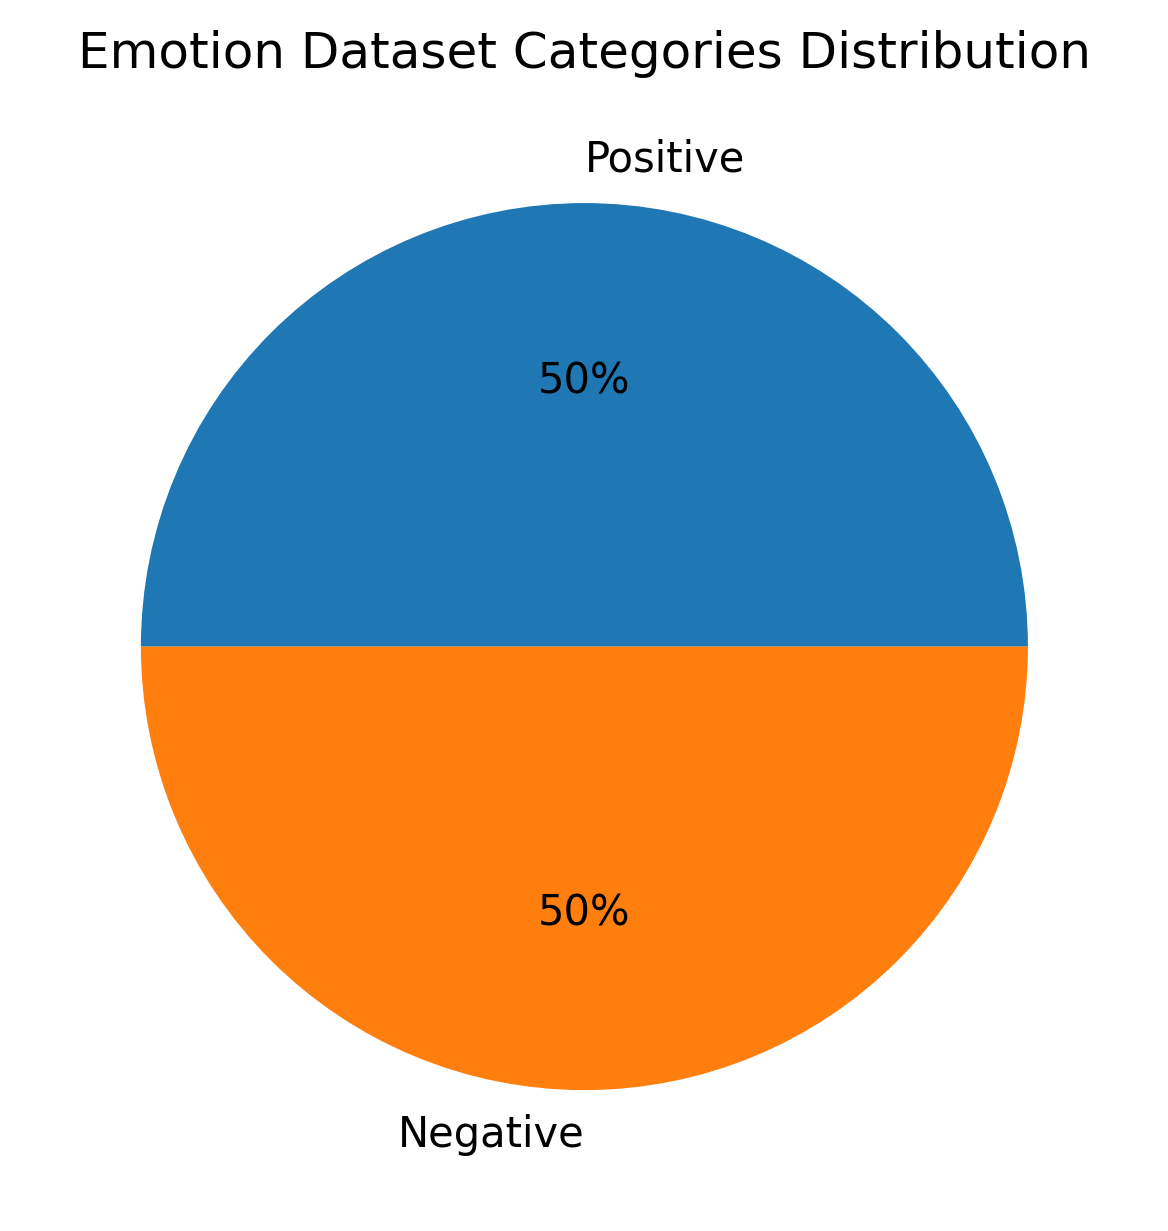

In [ ]:
categories = {"Positive":0, "Negative": 0}
for cat in Y:
  if cat == 1:
    categories["Positive"] = categories["Positive"] + 1
  elif cat == 0:
    categories["Negative"] = categories["Negative"] + 1

cat = categories.keys()
val = []
for keys in cat:
  val.append(categories[keys])

plt.figure(dpi=300)
plt.pie(val, labels = cat, autopct='%1.0f%%')
plt.title('Emotion Dataset Categories Distribution')
plt.savefig("./image/Emopie")
plt.show()

**Tokenization**

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

X = []
for lyric in lyrics:
    tokens = word_tokenize(lyric)
    X.append(tokens)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
filename = './glove.6B.100d.txt'
# Collection Word relationship
file = open(filename, encoding = "utf-8")
embed_DB = {}
for a_line in file:
    embedding = a_line.split()
    the_word = embedding[0]
    context_array = embedding[1:]
    embed_DB[the_word] = np.asarray(context_array)
file.close()

# Tokenizing lyrics words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
x_sequence = tokenizer.texts_to_sequences(X)

highest_tokens = max([len(tokenized_lyric) for tokenized_lyric in X])
x_sequence_zero = pad_sequences(x_sequence, maxlen=highest_tokens)

word_index = tokenizer.word_index
total_words = len(word_index) + 1

embed_mat = np.zeros((total_words, 100))

# Making embedding matrix
for word, index in word_index.items():
    if index > total_words:
        continue
    embed_vec = embed_DB.get(word)
    # edge cases
    if embed_vec is None:
      continue
    embed_mat[index] = embed_vec

embedding_layer = Embedding(total_words, 100, embeddings_initializer=Constant(embed_mat), input_length=highest_tokens,trainable=False)

Sperating Training and Test Dataset

In [ ]:
Y = np.array(Y)
encoder = LabelBinarizer()
Y = encoder.fit_transform(Y.tolist())
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)

Functions to calculate recall, precision and F1 score

In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Model

In [ ]:
"""model = Sequential()
embedding_layer = Embedding(total_words, 100, embeddings_initializer=Constant(embed_mat), input_length=highest_tokens,trainable=False)
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(128, 16, activation='relu'))
model.add(Conv1D(64, 8, activation='relu'))
model.add(Conv1D(32, 8, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m,precision_m, recall_m])
"""
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.2))
model.add(Conv1D(128, 16, activation='relu'))
model.add(Conv1D(64, 8, activation='relu'))
model.add(Conv1D(32, 8, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
history_model = model.fit(X_train, Y_train, batch_size=16, epochs=10, validation_data=(X_test, Y_train), verbose=2)

Epoch 1/10
100/100 - 3s - loss: 0.5297 - accuracy: 0.6894 - f1_m: 0.7418 - precision_m: 0.7027 - recall_m: 0.8849 - val_loss: 0.2931 - val_accuracy: 0.8750 - val_f1_m: 0.8740 - val_precision_m: 0.8365 - val_recall_m: 0.9329 - 3s/epoch - 29ms/step
Epoch 2/10
100/100 - 0s - loss: 0.2474 - accuracy: 0.8850 - f1_m: 0.8748 - precision_m: 0.8950 - recall_m: 0.8817 - val_loss: 0.2439 - val_accuracy: 0.8875 - val_f1_m: 0.8848 - val_precision_m: 0.8567 - val_recall_m: 0.9313 - 476ms/epoch - 5ms/step
Epoch 3/10
100/100 - 0s - loss: 0.1961 - accuracy: 0.9200 - f1_m: 0.9167 - precision_m: 0.9394 - recall_m: 0.9105 - val_loss: 0.1876 - val_accuracy: 0.9100 - val_f1_m: 0.9027 - val_precision_m: 0.9092 - val_recall_m: 0.9116 - 465ms/epoch - 5ms/step
Epoch 4/10
100/100 - 1s - loss: 0.1951 - accuracy: 0.9212 - f1_m: 0.9191 - precision_m: 0.9365 - recall_m: 0.9181 - val_loss: 0.2831 - val_accuracy: 0.8725 - val_f1_m: 0.8748 - val_precision_m: 0.8019 - val_recall_m: 0.9769 - 511ms/epoch - 5ms/step
Epoch 

Confusion Matrix

13/13 [==============================] - 0s 2ms/step


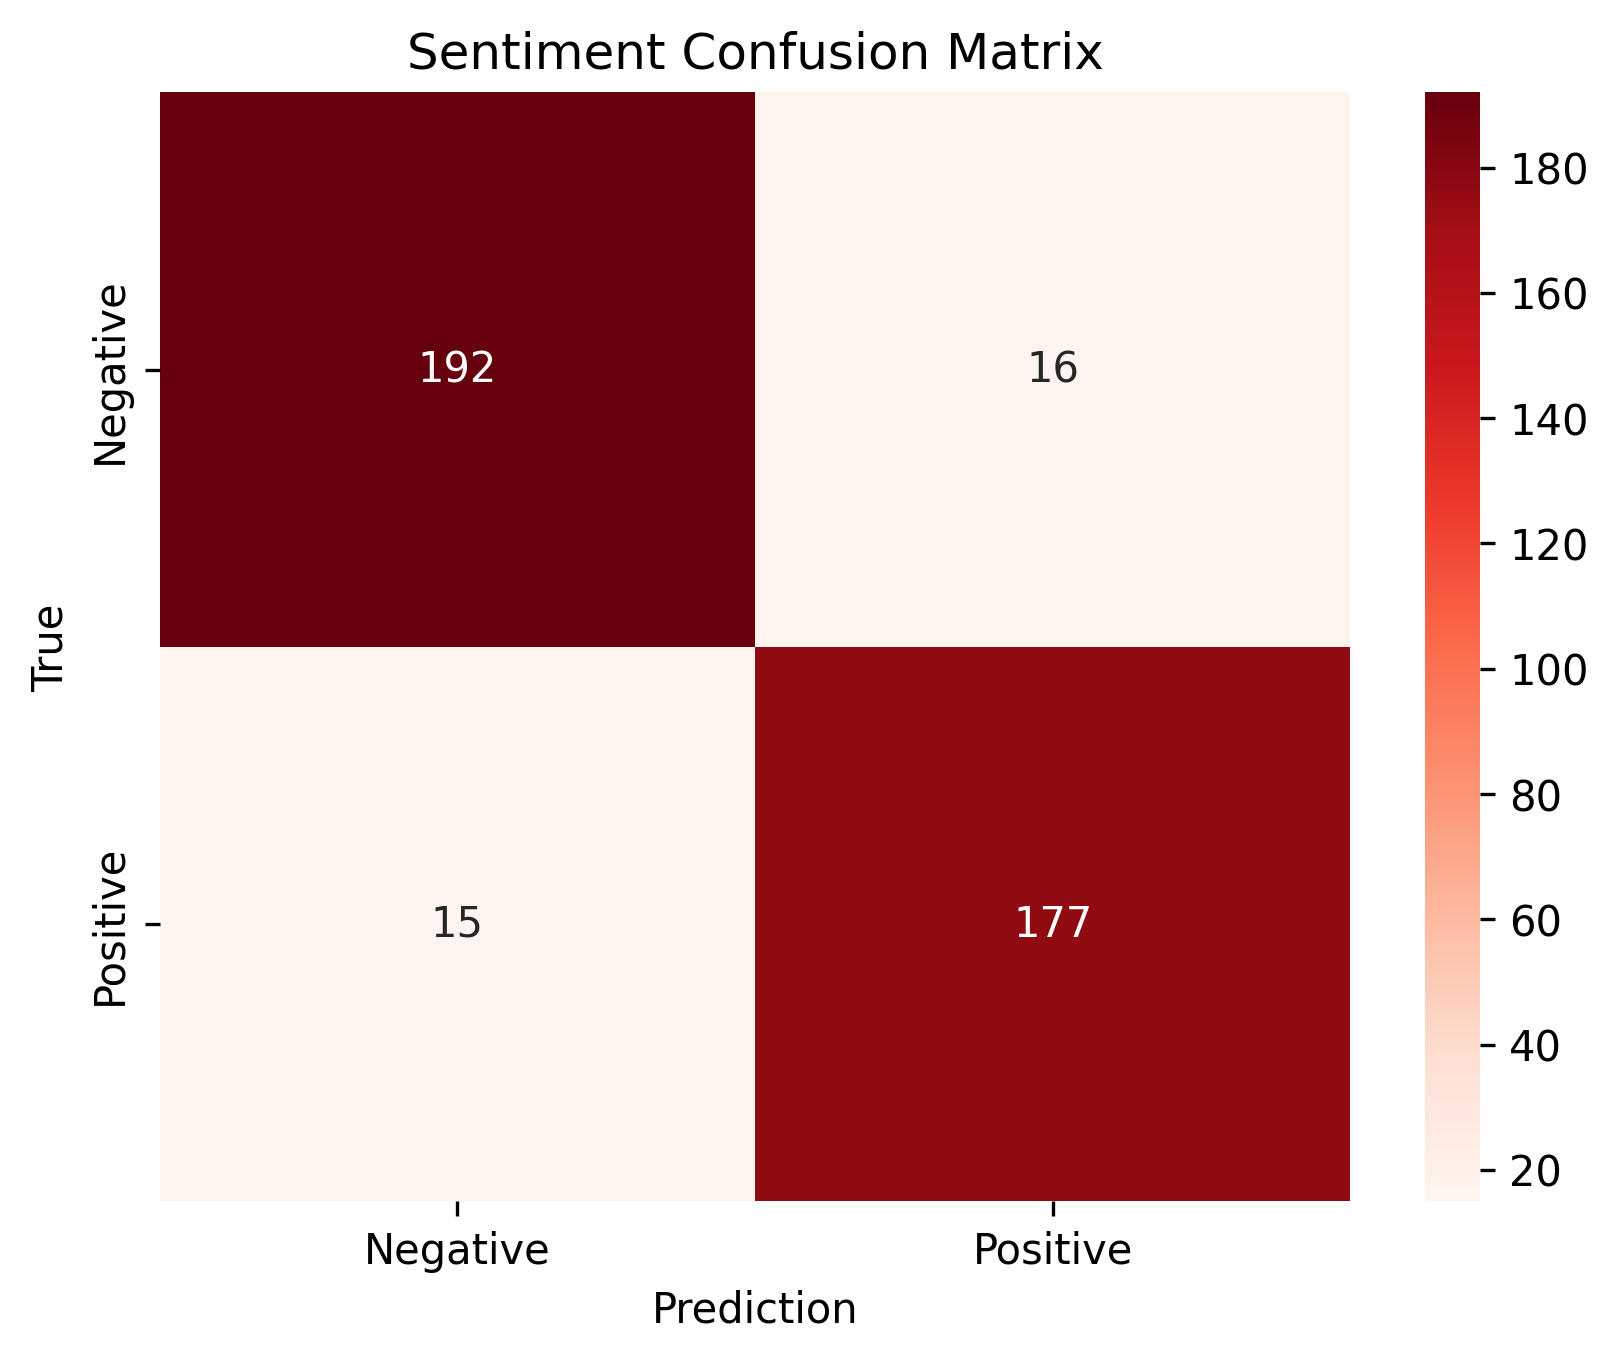

In [ ]:
Y_pred = np.around(model.predict(X_test), dtype=int).flatten()

confusion_mat = confusion_matrix(Y_test, Y_pred)
confusion_df = pd.DataFrame(confusion_mat, index = ['Negative', 'Positive'], columns = ['Negative', 'Positive'])

figure(dpi=300)
sn.heatmap(confusion_df, annot=True, cmap=plt.cm.Reds, fmt='g', cbar=True)
plt.title('Sentiment Confusion Matrix')
plt.xlabel("Prediction")
plt.ylabel("True")
plt.savefig("./image/Sentiment confusion mat")
plt.show()

Accuracy

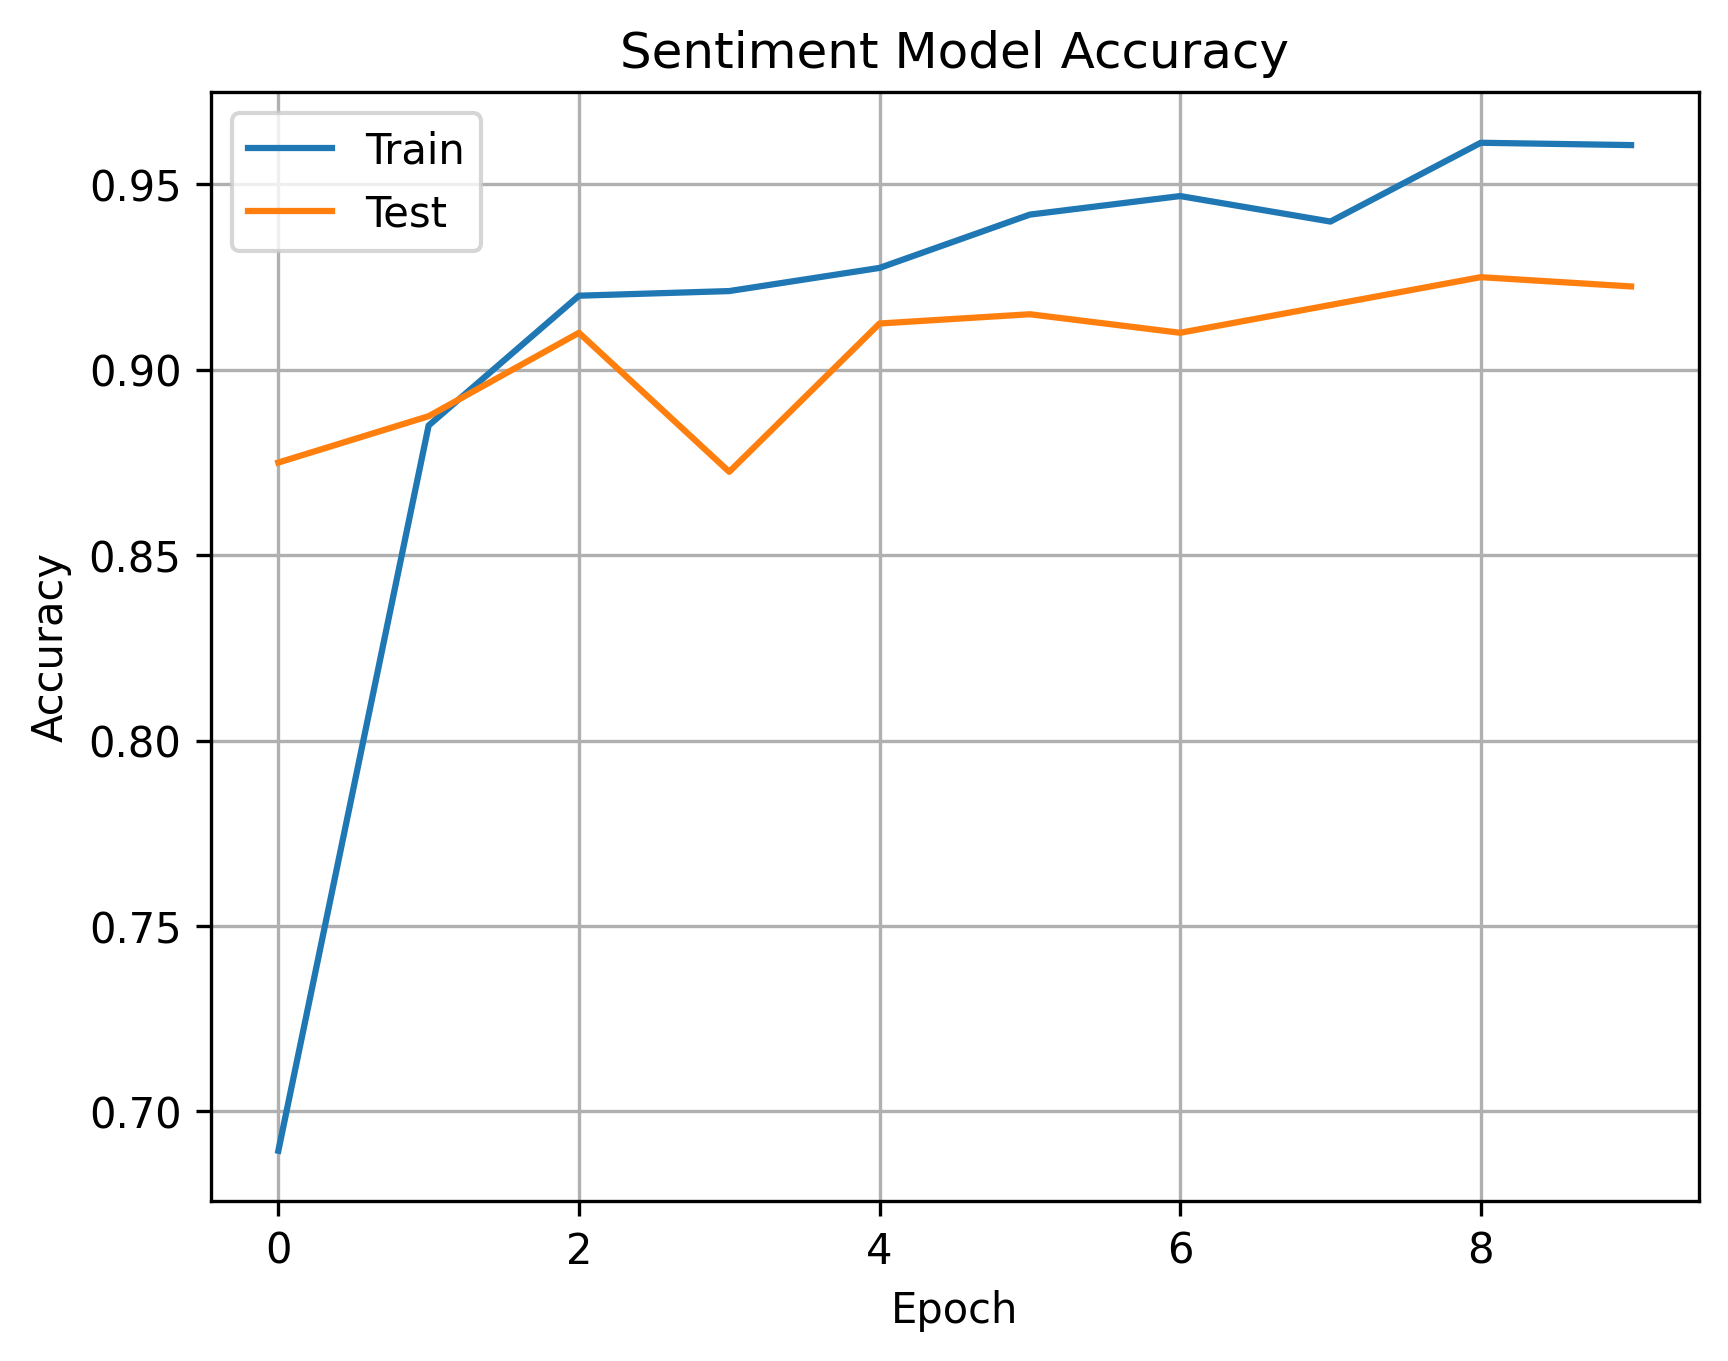

In [ ]:
figure(dpi=300)
plt.plot(history_model.history['accuracy'])
plt.plot(history_model.history['val_accuracy'])
plt.title('Sentiment Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.grid(True)
plt.savefig("./image/Sentiment accuracy mat")
plt.show()

Loss

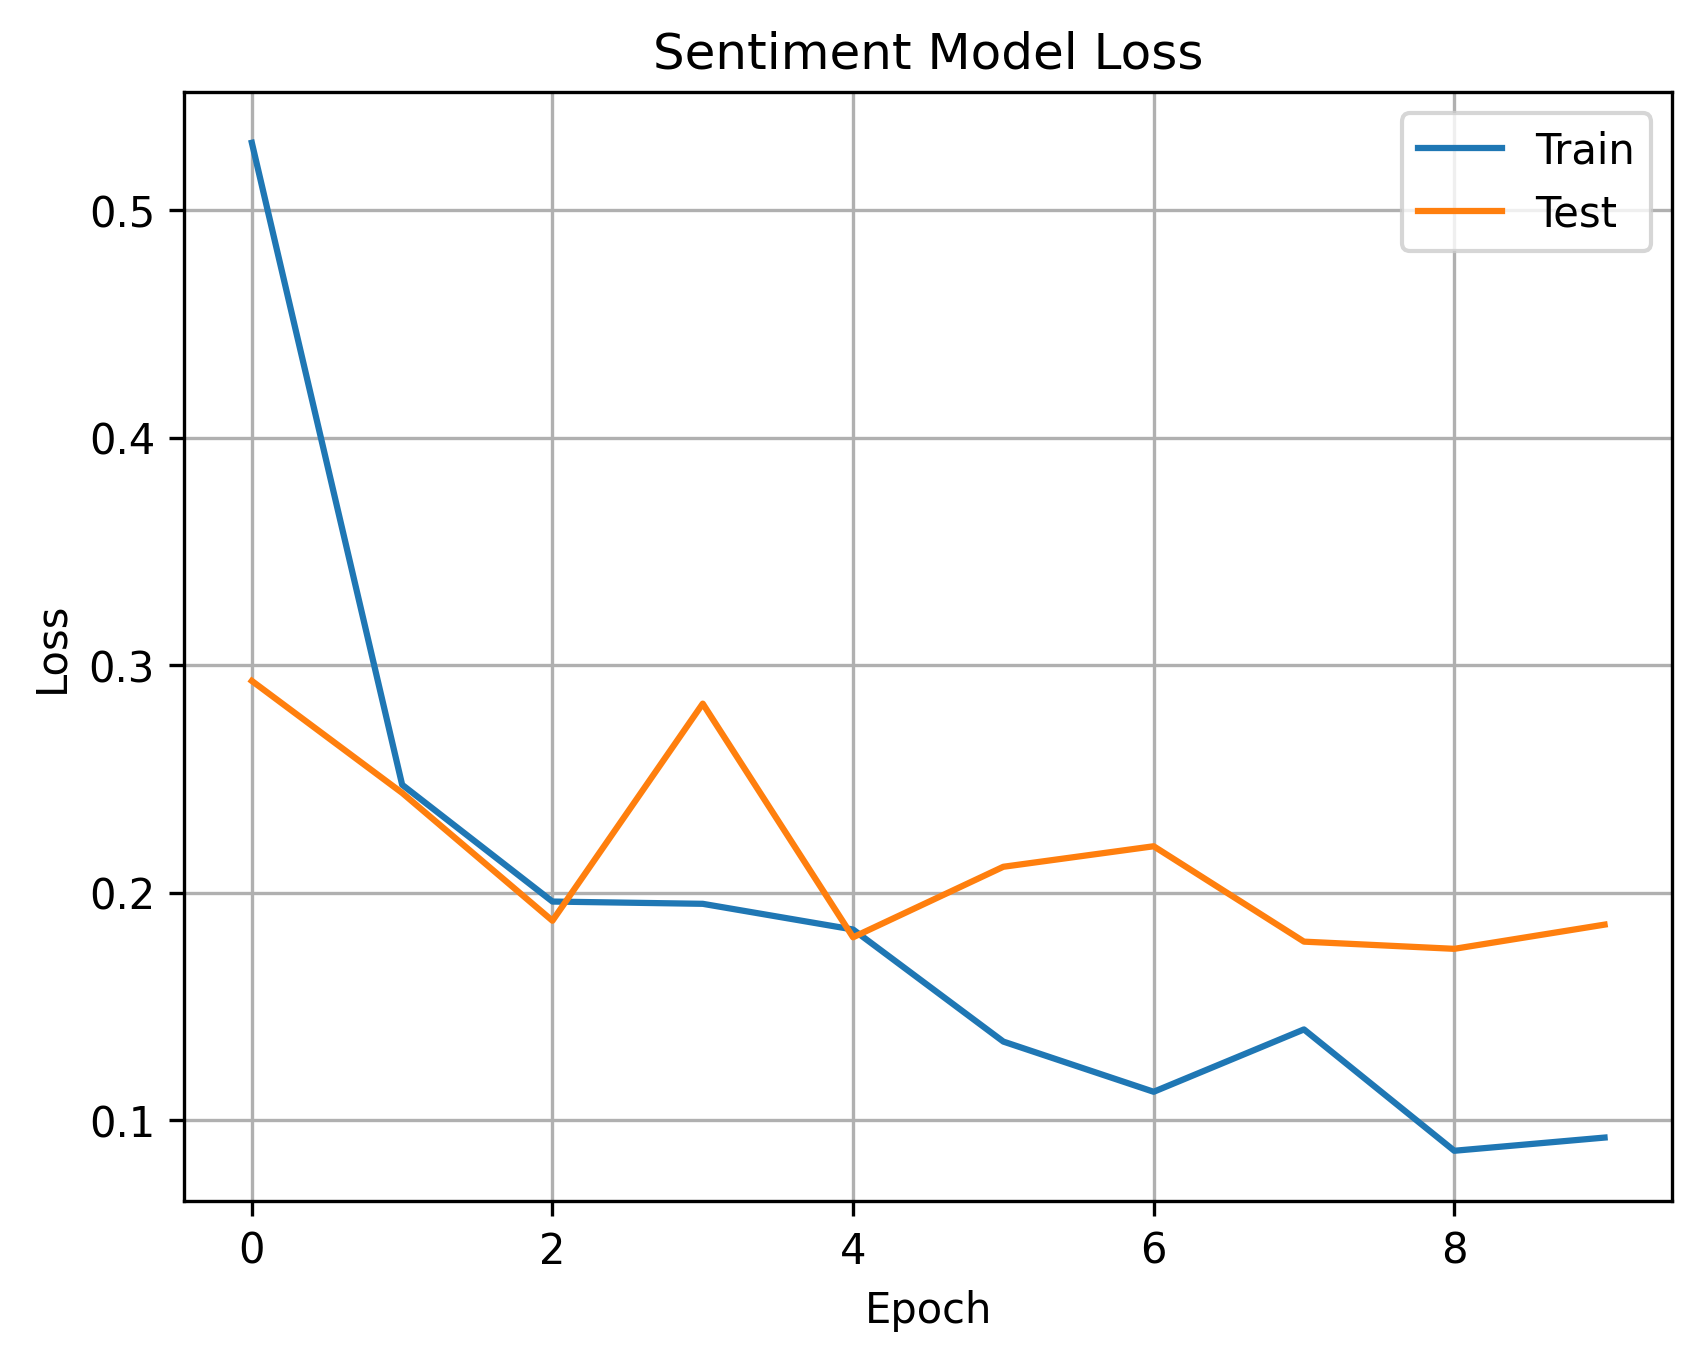

In [ ]:
figure(dpi=300)
plt.plot(history_model.history['loss'])
plt.plot(history_model.history['val_loss'])
plt.title('Sentiment Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.grid(True)
plt.savefig("./image/Sentiment loss mat")
plt.show()

Recall

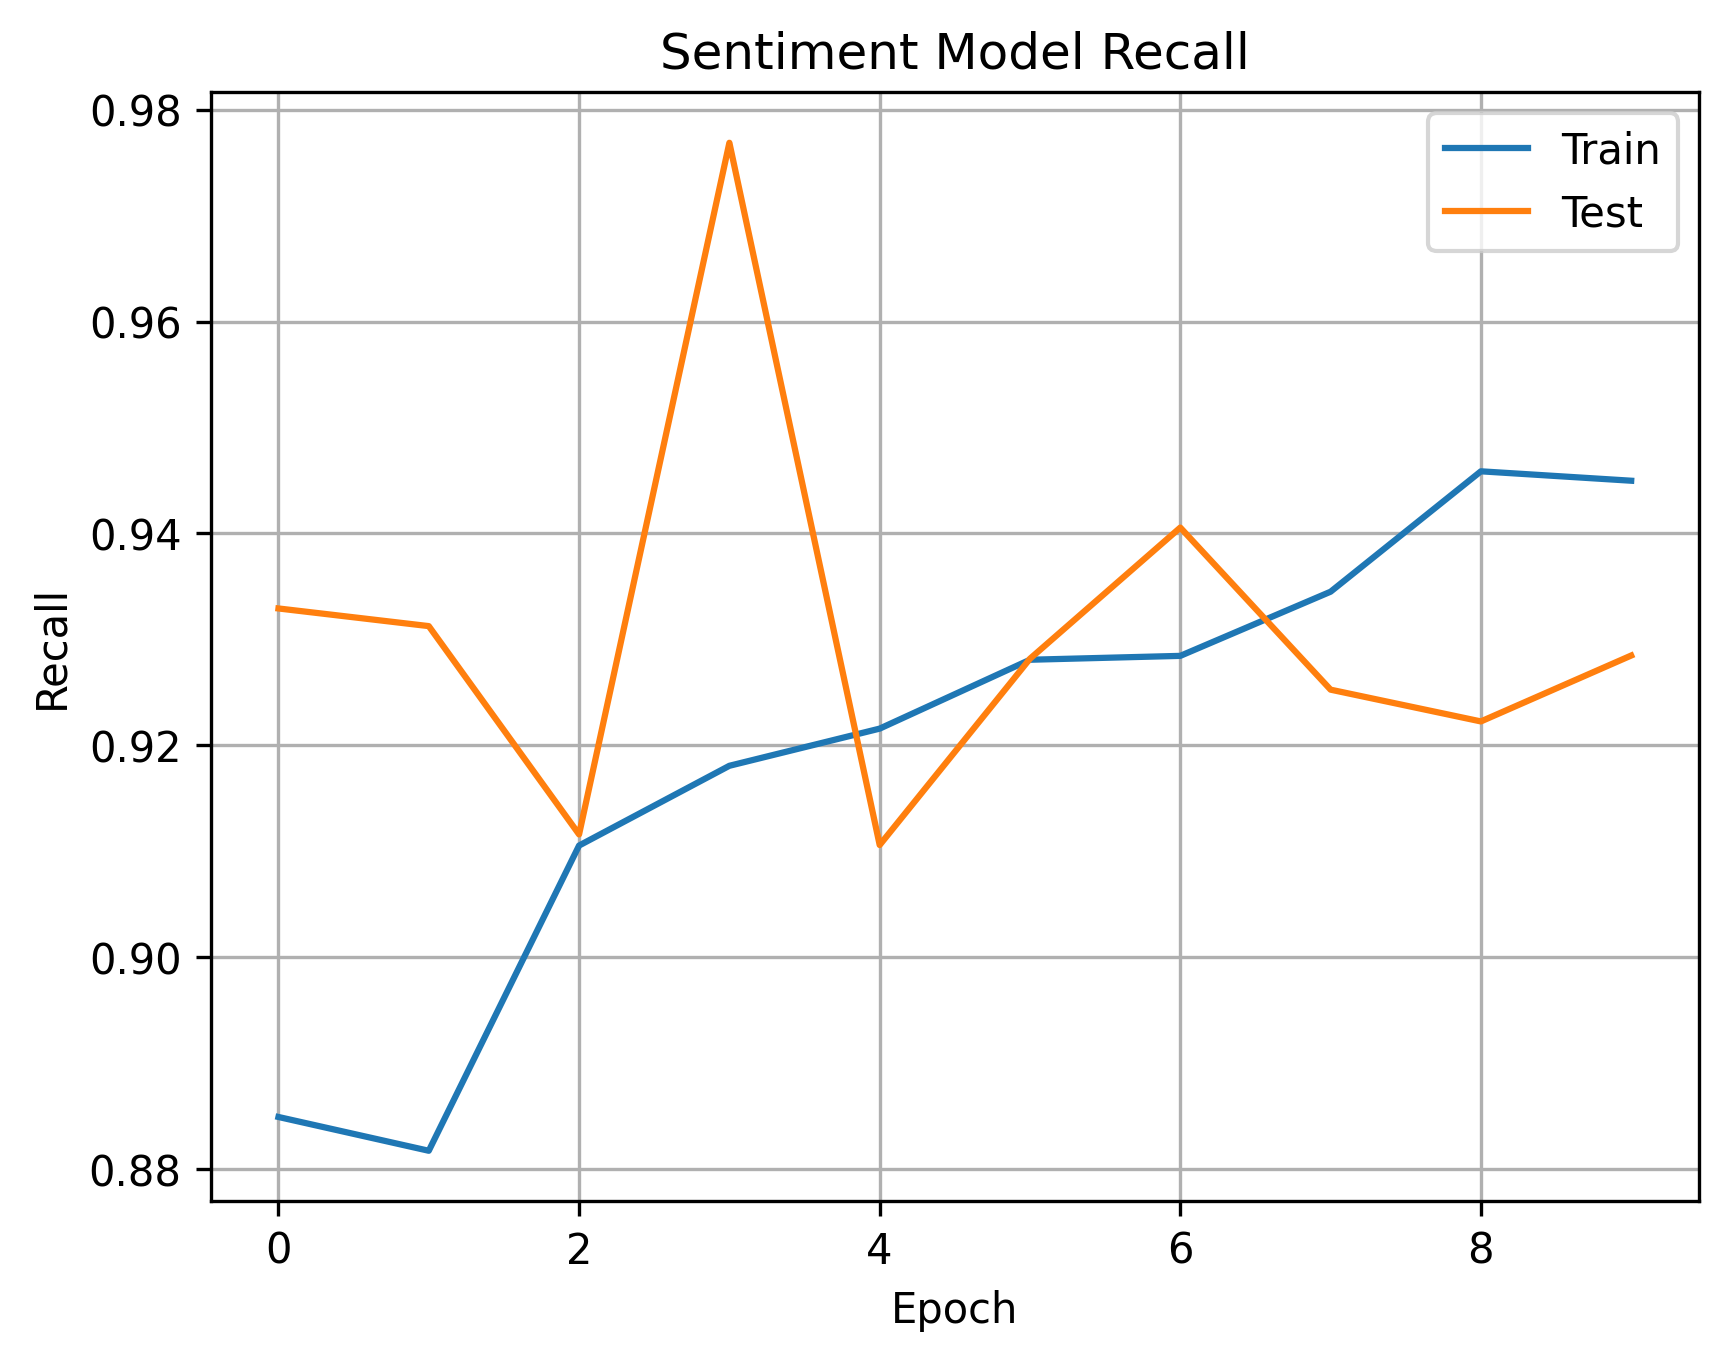

In [ ]:
figure(dpi=300)
plt.plot(history_model.history['recall_m'])
plt.plot(history_model.history['val_recall_m'])
plt.title('Sentiment Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.grid(True)
plt.savefig("./image/Sentiment recall mat")
plt.show()

Precsion

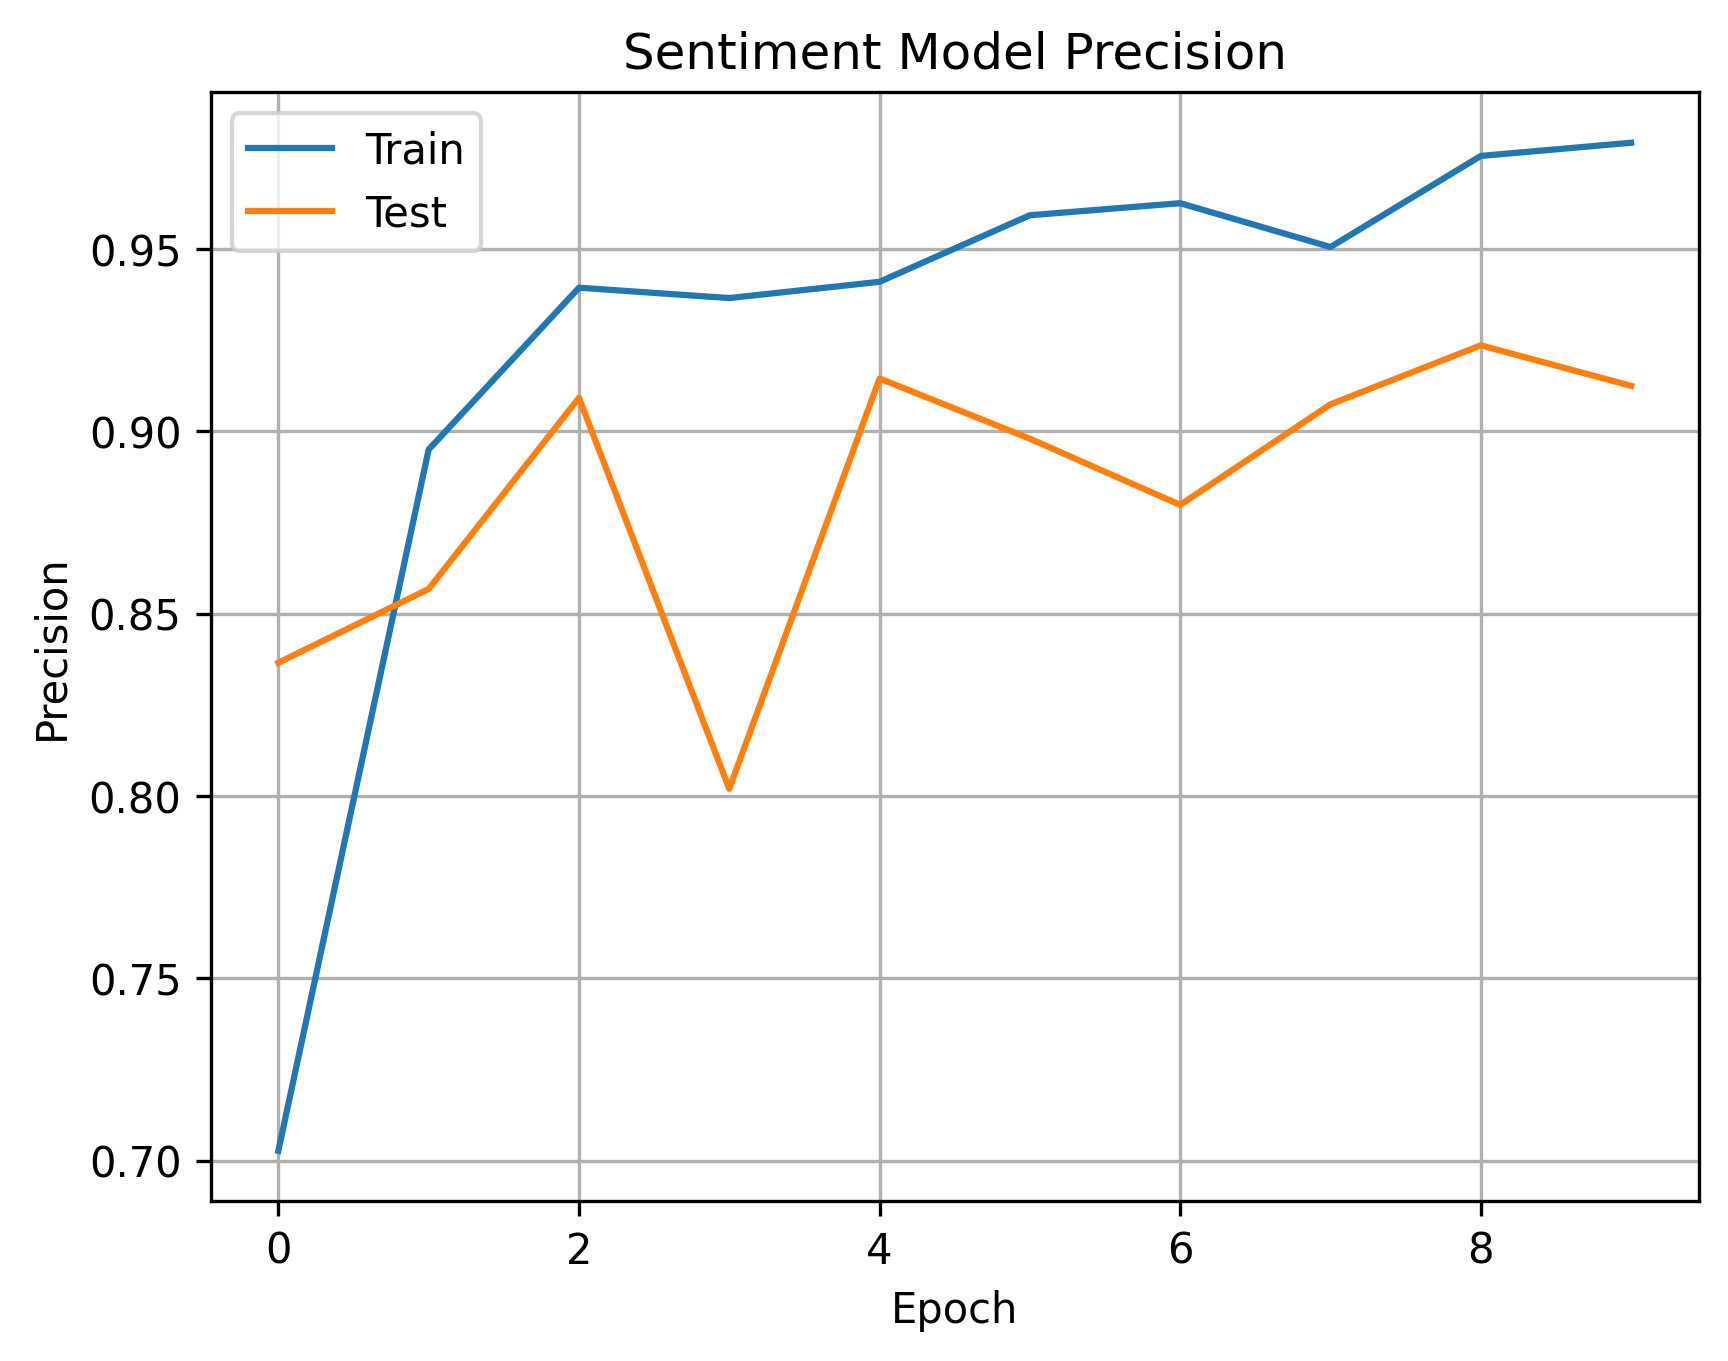

In [ ]:
figure(dpi=300)
plt.plot(history_model.history['precision_m'])
plt.plot(history_model.history['val_precision_m'])
plt.title('Sentiment Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.grid(True)
plt.savefig("./image/Sentiment precision mat")
plt.show()

F1 score

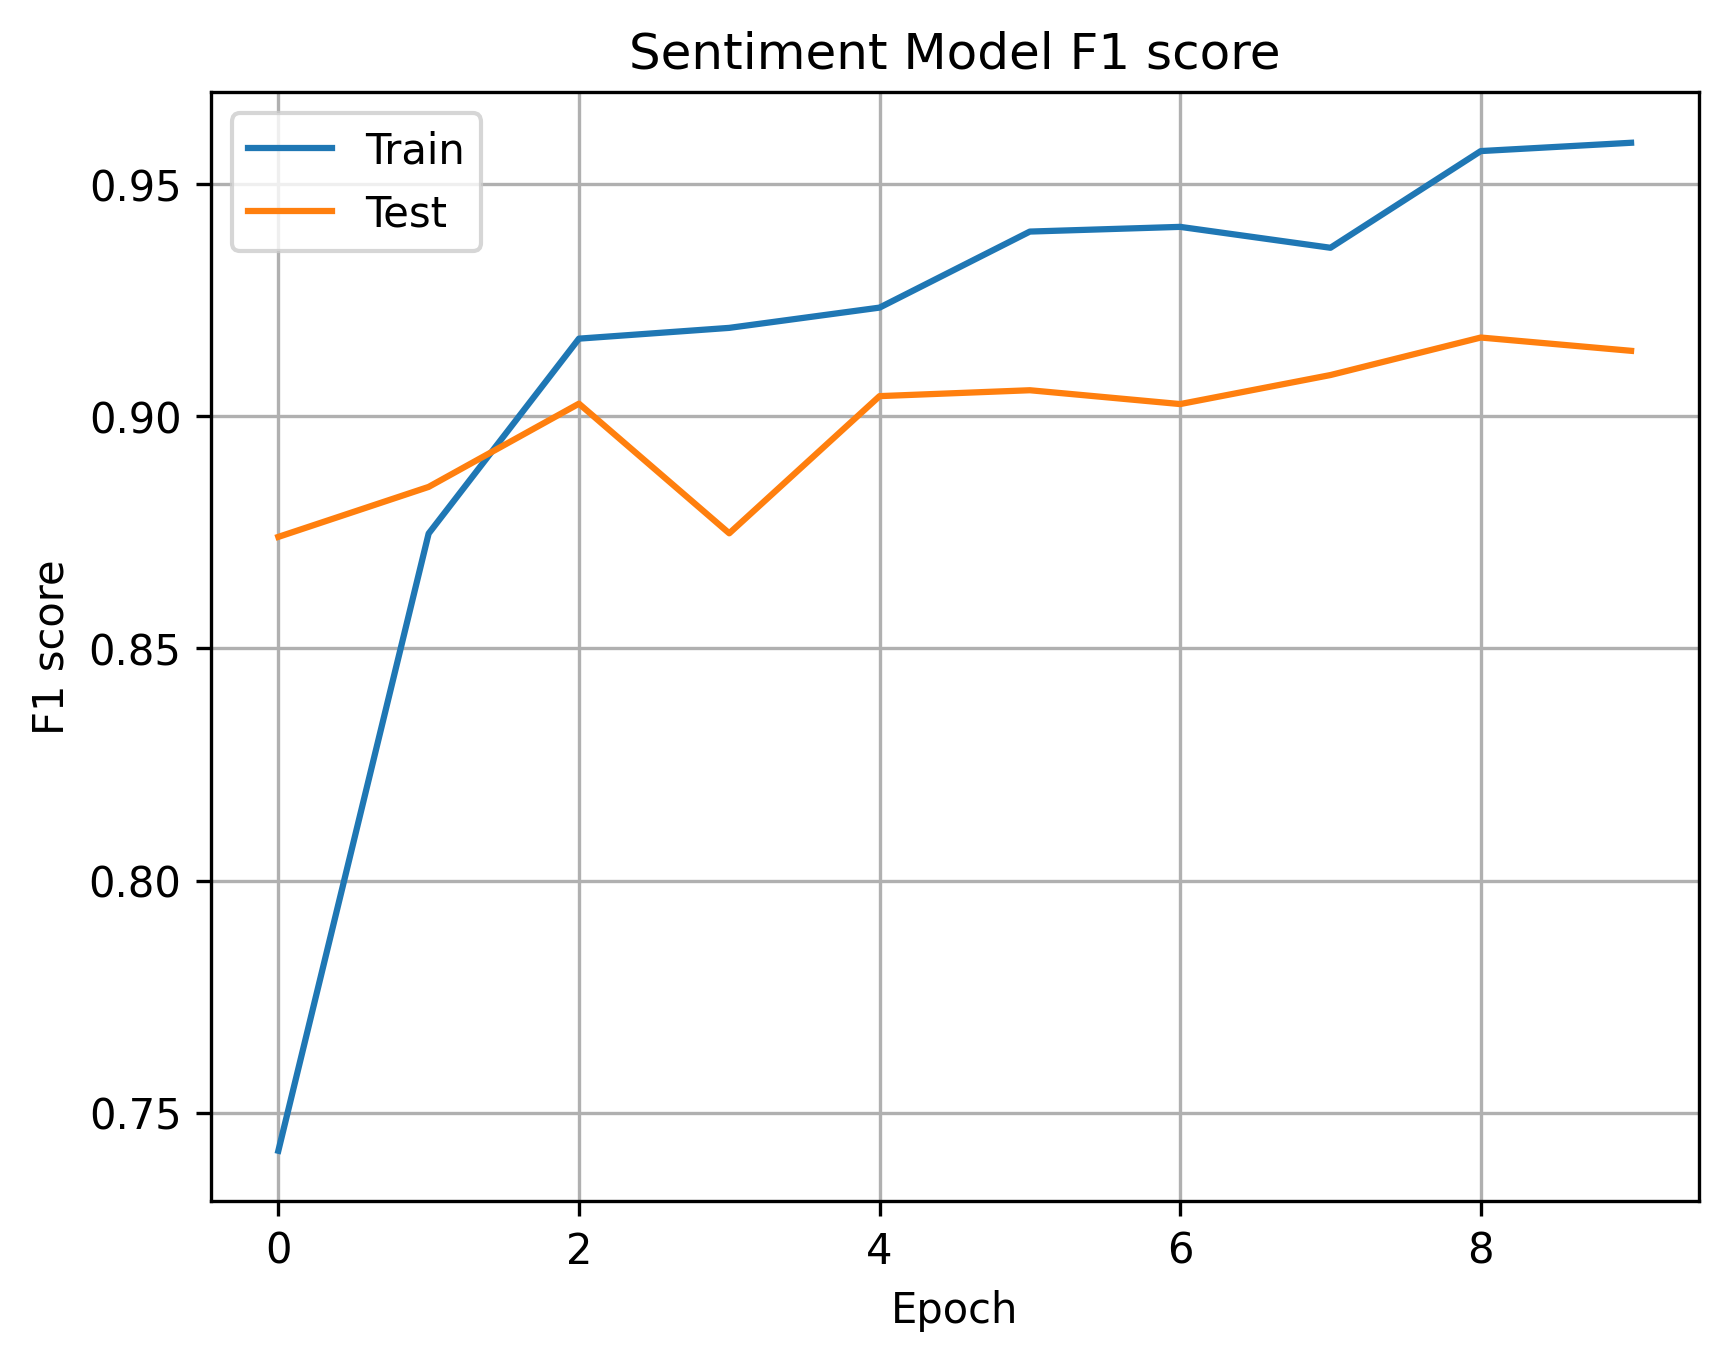

In [ ]:
figure(dpi=300)
plt.plot(history_model.history['f1_m'])
plt.plot(history_model.history['val_f1_m'])
plt.title('Sentiment Model F1 score')
plt.ylabel('F1 score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.grid(True)
plt.savefig("./image/Sentiment f1 mat")
plt.show()

Model Summary

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 584, 100)          1389800   
                                                                 
 dropout_2 (Dropout)         (None, 584, 100)          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 569, 128)          204928    
                                                                 
 conv1d_7 (Conv1D)           (None, 562, 64)           65600     
                                                                 
 conv1d_8 (Conv1D)           (None, 555, 32)           16416     
                                                                 
 global_max_pooling1d_2 (Gl  (None, 32)                0         
 obalMaxPooling1D)                                               
                                                      

Model Diagram

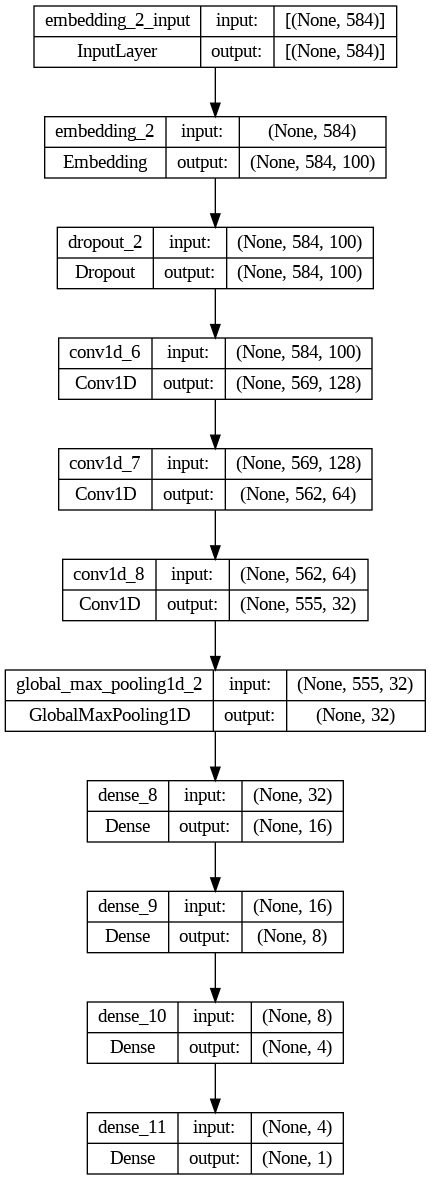

In [ ]:
plot_model(model, to_file='./image/Sentimentdia.png', show_shapes=True, show_layer_names=True)